In [ ]:
import os, time
from tqdm import tqdm
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint

from keras import backend as K

from keras.datasets import mnist

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMG_ROWS, IMG_COLS, CHANNELS = 64, 52, 3
IMG_ROWS_EVAL, IMG_COLS_EVAL = 64, 52

***

In [ ]:
dir_data      = "../img_align_celeba" #"data/img_align_celeba/"
Ntrain        = 162770
Ntest         = 19962


nm_imgs       = np.sort(os.listdir(dir_data))
print(nm_imgs.shape)
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]

def get_npdata(nm_imgs_train, img_rows = IMG_ROWS, img_cols = IMG_COLS):
    X_train = np.zeros([nm_imgs_train.shape[0], img_rows, img_cols, CHANNELS], dtype='uint8')
    for i, myid in enumerate(nm_imgs_train):
        X_train[i] = np.array(img_to_array(cv2.resize(cv2.imread(dir_data + "/" + myid)[...,::-1], dsize=(img_cols, img_rows), interpolation=cv2.INTER_AREA)))
    return(X_train)

X_train = get_npdata(nm_imgs_train, IMG_ROWS, IMG_COLS)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test, IMG_ROWS_EVAL, IMG_COLS_EVAL)
print("X_test.shape = {}".format(X_test.shape))

In [ ]:
# np.save("X_train-full_162770-res_64x52.npy", X_train)
# np.save("X_test-full_19962-res_64x52.npy", X_test)

***

In [4]:
X_train = np.load("X_train-full_162770-res_64x52.npy")
X_test = np.load("X_test-full_19962-res_64x52.npy")

---

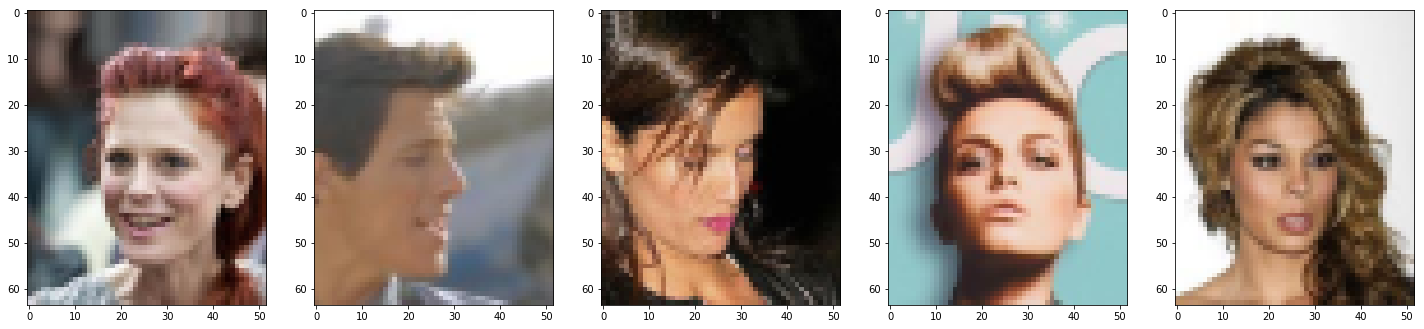

In [5]:
fig = plt.figure(figsize=(30,10))
nplot = 6
for count in range(1, nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

---

In [6]:
def img_coordinates(img_rows, img_cols):
    # [img_rows, img_cols]
    row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
    # [img_cols, img_rows]
    col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
    # [img_rows*img_cols, 2]
    x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [img_rows*img_cols,2])
    
    return x_pairs

In [7]:
def generate_data(batch_size, max_num_context, img_rows, img_cols, testing=False, index=None, num_context=None):
    
    max_num_points = img_rows*img_cols
    if num_context == None:
        if max_num_context > max_num_points:
            num_context = np.random.randint(3, max_num_points, dtype='int32')
        else:
            num_context = np.random.randint(3, max_num_context, dtype='int32')
    
    if testing:
        num_target_points = max_num_points
        set_x = X_test
    else:
        num_target_points = np.random.randint(num_context, max_num_points+1, dtype='int32')
        set_x = X_train
    
    context_x = np.zeros([batch_size, num_context, 2])
    context_y = np.zeros([batch_size, num_context, CHANNELS])
    
    target_x = np.zeros([batch_size, num_target_points, 2])
    target_y = np.zeros([batch_size, num_target_points, CHANNELS])
    
    x_pairs = img_coordinates(img_rows, img_cols)
    
    if index!=None:
        idx_1 = np.array([index])
    else:
        idx_1 = np.arange(set_x.shape[0])
        np.random.shuffle(idx_1)
        
    for i in range(batch_size):
        
        img = np.reshape(set_x[idx_1[i]], [max_num_points, CHANNELS])/255
        
        idx_2 = np.arange(max_num_points)
        np.random.shuffle(idx_2)
        
        context_x[i] = x_pairs[idx_2[:num_context]]
        context_y[i] = img[idx_2[:num_context]]
        
        if testing:
            target_x[i] = x_pairs
            target_y[i] = img
        else:
            target_x[i] = x_pairs[idx_2[:num_target_points]]
            target_y[i] = img[idx_2[:num_target_points]]


    context_xy = np.concatenate([context_x, context_y], axis=-1)
    
    return [context_xy, target_x], target_y   

In [8]:
def generate(batch_size, max_num_context, img_rows, img_cols, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_data(batch_size, max_num_context, img_rows, img_cols, testing=testing)
        yield (inputs, targets)

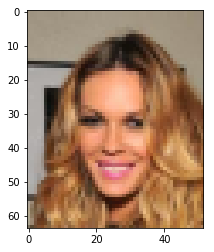

In [9]:
[context_xy, target_x], target_y = generate_data(1, IMG_ROWS_EVAL*IMG_COLS_EVAL, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True)
plt.imshow(np.array(np.round(target_y[0]*255), dtype='uint8').reshape([IMG_ROWS_EVAL, IMG_COLS_EVAL,3]))
plt.show()

---

In [10]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

___


In [11]:
"""encoder"""
input_context_xy = Input((None, 2+CHANNELS), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 2), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
# encoder = Dense(128, activation='relu', name="Encoder_layer_3")(encoder)
# encoder = Dense(128, activation='relu', name="Encoder_layer_4")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_3")(encoder)


"""aggregate"""
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


"""decoder"""
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_2")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_3")(decoder)
# decoder = Dense(128, activation='relu', name="Decoder_layer_4")(decoder)
# decoder = Dense(128, activation='relu', name="Decoder_layer_5")(decoder)
decoder = Dense(2*CHANNELS, activation='linear', name="Decoder_layer_4")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)


"""build model"""
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

model.load_weights("CNP_celebA_e4_d5_v3_b500_rs64x52.h5")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 5)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    768         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
_____

___


In [12]:
def process_to_plot(inputs, target_y, pred, img_rows, img_cols):
    
    target_y = np.array(np.round(target_y[0]*255), dtype='uint8').reshape([img_rows, img_cols,3])

    context_x = np.array(np.round(np.matmul(inputs[0][0, :, :2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2:]*255), dtype='uint8')
    
    context_img = np.zeros([img_rows, img_cols, 3], dtype='uint8')
    context_img[:,:,2] = 255 # set background blue
    for i in range(context_x.shape[0]):
        context_img[context_x[i,0], context_x[i,1], :] = context_y[i]

    pred_y = np.array(np.round(np.clip(pred[0, :, :3], 0.0, 1.0)*255), dtype='uint8').reshape([img_rows, img_cols,3])
    
#     for i in range(context_x.shape[0]):
#         pred_y[context_x[i,0], context_x[i,1], :] = context_y[i]

    var    = np.array(np.round(np.clip(pred[0, :, 3:], 0.0, 1.0)*255), dtype='uint8').reshape([img_rows, img_cols,3])

    return target_y, pred_y, context_img, var, img_rows*img_cols, context_x.shape[0]

In [25]:
def plot_function_1(target_y, pred_y, context_img, var, max_context, num_context):
    font_s=18
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(6,6))
    ax1.imshow(target_y)
    ax1.set_title("True", fontsize = font_s)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(pred_y)
    ax2.set_title("Predict", fontsize = font_s)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.imshow(context_img)
    ax3.set_title("Context Points: \n Num pts=%i/%i" % (num_context, max_context), fontsize = font_s)
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4.imshow(var)
    ax4.set_title("Variance", fontsize = font_s)
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    fig.tight_layout()
    
#     plt.savefig('celebA1_1000dpi.png', dpi = 1000, bbox_inches = 'tight')

    plt.show()

---

In [15]:
MAX_CONTEXT_POINTS = 25e3

repeats = 10
epochs = 5
steps_per_epoch = 2e2
steps_per_validation = 2e2
batch_size = 500

log: r15, e1, spe2e2, spv2e2, b500 &nbsp;&nbsp;&nbsp; CNP_celebA_e4_d5_v1_b500_rs64x52.h5<br>
log: r25, e5, spe2e2, spv2e2, b500 &nbsp;&nbsp;&nbsp; CNP_celebA_e4_d5_v2_b500_rs64x52.h5<br>
log: r10, e5, spe2e2, spv2e2, b500 &nbsp;&nbsp;&nbsp; CNP_celebA_e4_d5_v3_b500_rs64x52.h5<br>

Total Train: 38000 iterations of batch size <br>


Training model
*****************************
Repeat 1 : Fri Feb 21 10:01:43 2020
Epoch 1/5
200/200 [==============================] - 118s 588ms/step - loss: -2.4789 - val_loss: -2.3789
Epoch 2/5
200/200 [==============================] - 121s 606ms/step - loss: -2.4778 - val_loss: -1.7020
Epoch 3/5
200/200 [==============================] - 122s 608ms/step - loss: -2.4169 - val_loss: -2.5919
Epoch 4/5
200/200 [==============================] - 124s 618ms/step - loss: -2.4785 - val_loss: -2.3537
Epoch 5/5
200/200 [==============================] - 123s 616ms/step - loss: -2.5104 - val_loss: -2.5376


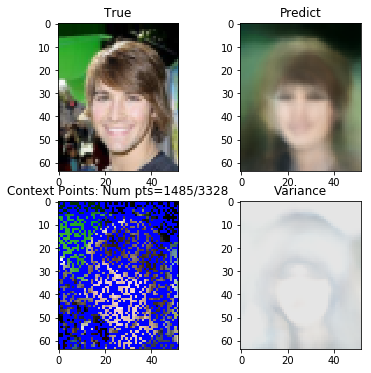

*****************************
Repeat 2 : Fri Feb 21 10:11:51 2020
Epoch 1/5
200/200 [==============================] - 125s 627ms/step - loss: -2.4453 - val_loss: -2.5594
Epoch 2/5
200/200 [==============================] - 122s 608ms/step - loss: -2.5113 - val_loss: -2.5840
Epoch 3/5
200/200 [==============================] - 120s 601ms/step - loss: -2.4631 - val_loss: -2.5922
Epoch 4/5
200/200 [==============================] - 123s 616ms/step - loss: -2.5102 - val_loss: -2.6059
Epoch 5/5
200/200 [==============================] - 125s 626ms/step - loss: -2.5121 - val_loss: -2.5960


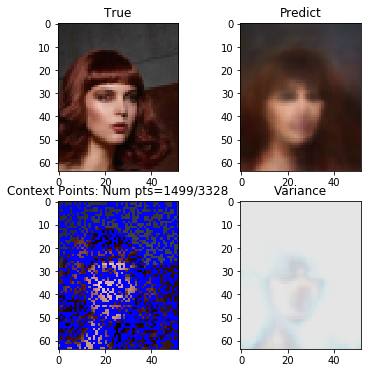

*****************************
Repeat 3 : Fri Feb 21 10:22:07 2020
Epoch 1/5
200/200 [==============================] - 123s 614ms/step - loss: -2.5000 - val_loss: -2.5885
Epoch 2/5
200/200 [==============================] - 123s 617ms/step - loss: -2.4816 - val_loss: -2.5802
Epoch 3/5
200/200 [==============================] - 122s 609ms/step - loss: -2.5001 - val_loss: -2.5820
Epoch 4/5
200/200 [==============================] - 124s 618ms/step - loss: -2.5003 - val_loss: -2.5227
Epoch 5/5
200/200 [==============================] - 124s 620ms/step - loss: -2.5430 - val_loss: -2.5623


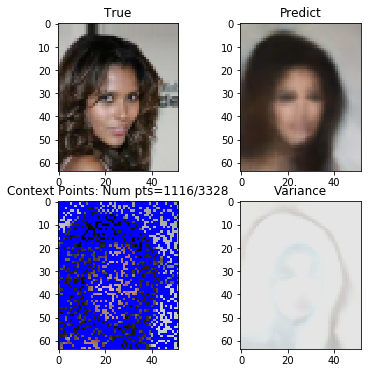

*****************************
Repeat 4 : Fri Feb 21 10:32:23 2020
Epoch 1/5
200/200 [==============================] - 119s 595ms/step - loss: -2.4169 - val_loss: -2.5908
Epoch 2/5
200/200 [==============================] - 124s 621ms/step - loss: -2.4831 - val_loss: -2.5715
Epoch 3/5
200/200 [==============================] - 123s 615ms/step - loss: -2.5136 - val_loss: -2.6091
Epoch 4/5
200/200 [==============================] - 124s 621ms/step - loss: -2.5311 - val_loss: -2.6449
Epoch 5/5
200/200 [==============================] - 125s 624ms/step - loss: -2.4322 - val_loss: -2.5626


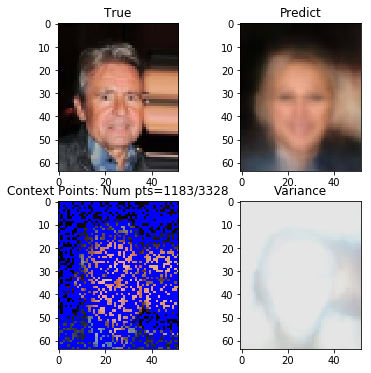

*****************************
Repeat 5 : Fri Feb 21 10:42:38 2020
Epoch 1/5
200/200 [==============================] - 120s 602ms/step - loss: -2.4847 - val_loss: -2.5562
Epoch 2/5
200/200 [==============================] - 125s 626ms/step - loss: -2.5033 - val_loss: -2.6280
Epoch 3/5
200/200 [==============================] - 123s 616ms/step - loss: -2.5106 - val_loss: -2.1645
Epoch 4/5
200/200 [==============================] - 123s 615ms/step - loss: -2.4921 - val_loss: -2.3790
Epoch 5/5
200/200 [==============================] - 121s 604ms/step - loss: -2.5059 - val_loss: -2.6012


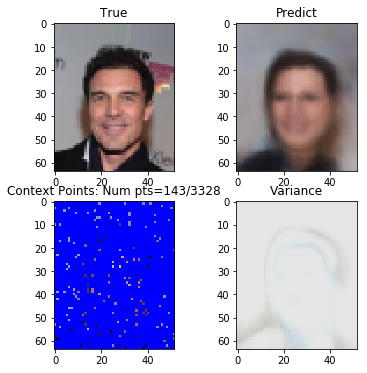

*****************************
Repeat 6 : Fri Feb 21 10:52:51 2020
Epoch 1/5
200/200 [==============================] - 121s 607ms/step - loss: -2.5045 - val_loss: -2.6690
Epoch 2/5
200/200 [==============================] - 122s 611ms/step - loss: -2.5450 - val_loss: -2.5844
Epoch 3/5
200/200 [==============================] - 122s 609ms/step - loss: -2.5202 - val_loss: -2.5863
Epoch 4/5
200/200 [==============================] - 121s 605ms/step - loss: -2.5523 - val_loss: -2.1578
Epoch 5/5
200/200 [==============================] - 125s 624ms/step - loss: -2.5529 - val_loss: -2.6421


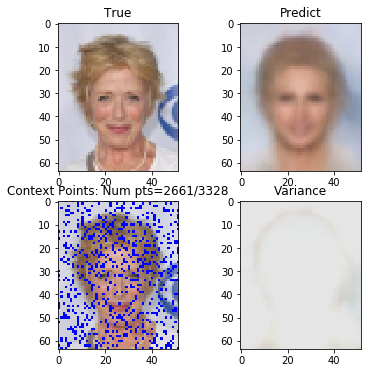

*****************************
Repeat 7 : Fri Feb 21 11:03:03 2020
Epoch 1/5
200/200 [==============================] - 124s 618ms/step - loss: -2.4926 - val_loss: -2.5820
Epoch 2/5
200/200 [==============================] - 119s 594ms/step - loss: -2.4874 - val_loss: -2.6192
Epoch 3/5
200/200 [==============================] - 123s 616ms/step - loss: -2.5190 - val_loss: -2.5969
Epoch 4/5
200/200 [==============================] - 121s 604ms/step - loss: -2.5224 - val_loss: -2.6284
Epoch 5/5
200/200 [==============================] - 120s 598ms/step - loss: -2.5308 - val_loss: -2.6206


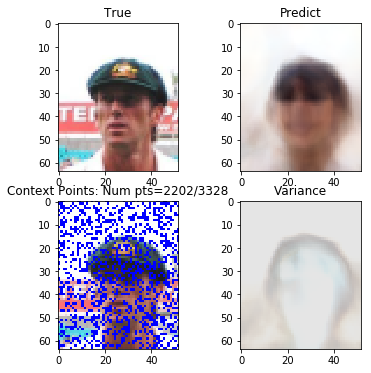

*****************************
Repeat 8 : Fri Feb 21 11:13:09 2020
Epoch 1/5
200/200 [==============================] - 124s 622ms/step - loss: -2.4874 - val_loss: -2.6031
Epoch 2/5
200/200 [==============================] - 120s 600ms/step - loss: -2.5108 - val_loss: -2.6301
Epoch 3/5
200/200 [==============================] - 122s 609ms/step - loss: -2.4881 - val_loss: -2.5909
Epoch 4/5
200/200 [==============================] - 124s 622ms/step - loss: -2.5236 - val_loss: -2.6110
Epoch 5/5
200/200 [==============================] - 118s 591ms/step - loss: -2.5207 - val_loss: -2.5492


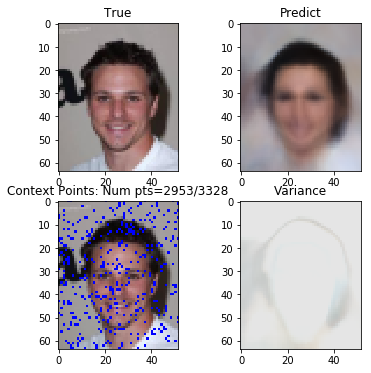

*****************************
Repeat 9 : Fri Feb 21 11:23:18 2020
Epoch 1/5
200/200 [==============================] - 124s 618ms/step - loss: -2.5082 - val_loss: -2.5364
Epoch 2/5
200/200 [==============================] - 122s 610ms/step - loss: -2.4880 - val_loss: -2.2608
Epoch 3/5
200/200 [==============================] - 121s 604ms/step - loss: -2.5140 - val_loss: -2.4216
Epoch 4/5
200/200 [==============================] - 123s 614ms/step - loss: -2.5080 - val_loss: -2.5275
Epoch 5/5
200/200 [==============================] - 125s 625ms/step - loss: -2.5137 - val_loss: -2.4953


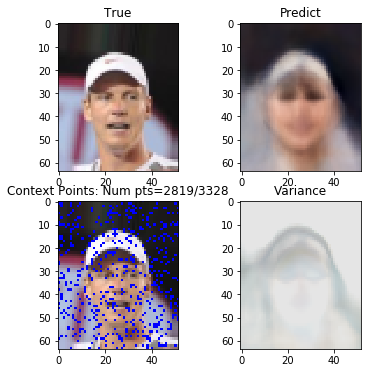

*****************************
Repeat 10 : Fri Feb 21 11:33:33 2020
Epoch 1/5
200/200 [==============================] - 124s 622ms/step - loss: -2.5695 - val_loss: -2.6614
Epoch 2/5
200/200 [==============================] - 122s 610ms/step - loss: -2.5571 - val_loss: -2.5551
Epoch 3/5
200/200 [==============================] - 122s 610ms/step - loss: -2.4495 - val_loss: -2.5354
Epoch 4/5
200/200 [==============================] - 122s 612ms/step - loss: -2.5483 - val_loss: -2.5866
Epoch 5/5
200/200 [==============================] - 120s 601ms/step - loss: -2.5257 - val_loss: -2.6335


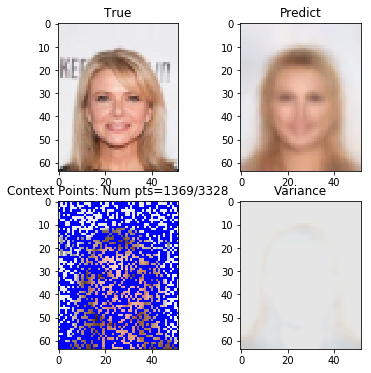

In [25]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i :" % (i+1), time.ctime())
    history = model.fit(generate(batch_size, MAX_CONTEXT_POINTS, IMG_ROWS, IMG_COLS, testing=False),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
#                         callbacks=[ModelCheckpoint('CNP_celebA_e4_d5_v2_b500_MIN_LOSS.h5', monitor='val_loss', save_best_only=True)],
                        validation_data=generate(batch_size, MAX_CONTEXT_POINTS, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True),
                        validation_steps=steps_per_validation)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y = generate_data(1, MAX_CONTEXT_POINTS, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True)
    pred = model.predict(inputs, steps=1)

    plot_function_1(*process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL))
    
# model.save_weights("CNP_celebA_e4_d5_v4_b500_rs64x52.h5")

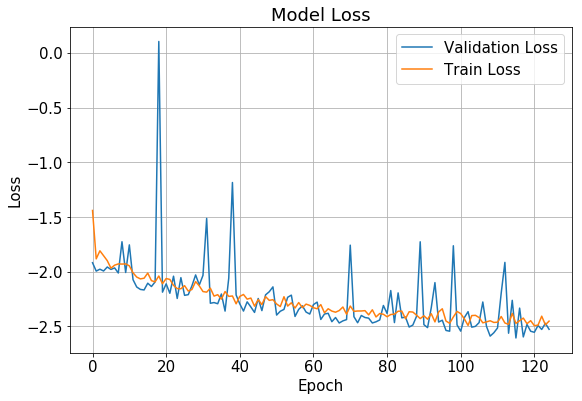

In [18]:
plt.figure(figsize=(9,6))
plt.plot(hist[1])
plt.plot(hist[0])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Validation Loss', 'Train Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()

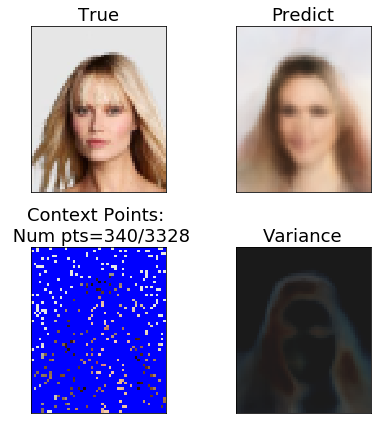

In [27]:

inputs, target_y = generate_data(1, None, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True, index=10, num_context=340)
pred = model.predict(inputs, steps=1)

plot_function_1(*process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL))

***

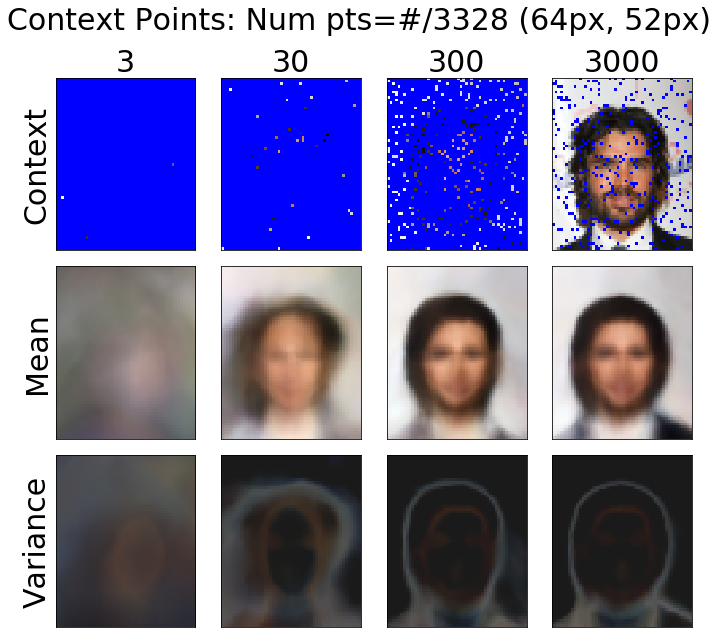

In [28]:
contexts_pts = np.array([3,30,300,3000])
labels = ["Context", "Mean", "Variance"]
font_s = 30

fig, ax = plt.subplots(3, 4, figsize=(2.44*contexts_pts.shape[0], 9))


for i in range(contexts_pts.shape[0]):
    inputs, target_y = generate_data(1, None, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True, index=1, num_context=contexts_pts[i])
    pred = model.predict(inputs, steps=1)

    _, pred_y, context_img, var, _, _ = process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL)
    
    ax[0, i].imshow(context_img)
    ax[0, i].set_title("%i" % (contexts_pts[i]), fontsize = font_s)
    
    ax[1, i].imshow(pred_y)
    ax[2, i].imshow(var)
    
    [ax[j, i].set_xticks([]) for j in range(len(labels))]
    [ax[j, i].set_yticks([]) for j in range(len(labels))]
    
    
[ax[j, 0].set_ylabel(labels[j], fontsize = font_s) for j in range(len(labels))]

fig.suptitle("Context Points: Num pts=#/%i (%ipx, %ipx)" % (IMG_ROWS_EVAL*IMG_COLS_EVAL, IMG_ROWS_EVAL, IMG_COLS_EVAL), fontsize = font_s)
fig.tight_layout()
fig.subplots_adjust(top=0.87)
# plt.savefig('celebA1_1000dpi.png', dpi = 1000, bbox_inches = 'tight')
plt.show()

***

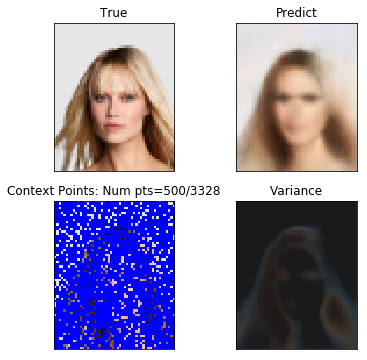

In [32]:

inputs, target_y = generate_data(1, 500, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True, index=10, num_context=500)
pred = model.predict(inputs, steps=1)

plot_function_1(*process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL))

In [74]:
def findLikeImages(inputs, img_rows, img_cols):
    context_x = np.array(np.round(np.matmul(inputs[0][0, :, :2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2:]*255), dtype='uint8')
    
#     setx = X_test
    setx = X_train
    
    mse = np.zeros(setx.shape[0])
    for i in tqdm(range(mse.shape[0])):
        for j in range(context_x.shape[0]):
            mse[i] += np.mean(np.power(setx[i, context_x[j, 0], context_x[j, 1]] - context_y[j], 2))
            
    idx = np.argsort(mse)
    return idx

In [ ]:
idx = findLikeImages(inputs, IMG_ROWS_EVAL, IMG_COLS_EVAL)

In [ ]:

fig = plt.figure(figsize=(30,15))
nplot = 5
for count in range(1, nplot):
    ax = fig.add_subplot(2,nplot,count)
    ax.imshow(X_test[idx[count-1]])

ax = fig.add_subplot(2,nplot,nplot+1)
ax.imshow(np.mean(X_test[idx[:50]], axis=0)/255)

pred_y = np.array(np.round(np.clip(pred[0, :, :3], 0.0, 1.0)*255), dtype='uint8').reshape([IMG_ROWS_EVAL, IMG_COLS_EVAL,3])
ax = fig.add_subplot(2,nplot,nplot+2)
ax.imshow(pred_y)

plt.show()